This notebook contains the code for the reproduction of the model runs on the wholesale electricity price dataset. This notebook should be ran before the notebook Evaluate_and_Visualize_Forecasts.ipynb, as the latter makes use of the already saved results files, which are genarated in this notebook. Due to limitations related to the size of the files, which can be uploaded on Quantlet, the results files are currently not stored in evaluation/Results, but can be downloaded from https://drive.google.com/drive/folders/1baGY-WEEm4mRNLokeBWiYqk2f_tuXIHd?usp=drive_link. Once the results files are downloaded and stored in evaluation/Results, the notebook Evaluate_and_Visualize_Forecasts.ipynb can be ran in order to reproduce the visualizations included in the paper. Alternatively, first cells in this notebook should be executed, which would save the results in evaluation/Results, and then the notebook Evaluate_and_Visualize_Forecasts.ipynb can be executed. The current notebook consists of the following sections:<br>
- **1. Data import and EDA**: this section imports the electricity price datasets, and generates a visualization related to the split of the dataset into multiple train and test sets.
- **2. Data preprocessing**: in this section the data is split into input and output sequences of 96 timesteps, which are then saved in separate pytorch dataloaders according to walk-forward validation.
- **3. Model training**: in this section in a loop all models are (trained and) tested on each split, and the results from each model using the walk-forward validation technique are saved in evaluation/Results. <br>

The code cell below should be ran first, in order to install any neccessary python packages, relevant for the reproduction of the results. Additionally, the python version used during the empirical research of the study is 3.11.7.

In [ ]:
!pip install -r requirements.txt

In [ ]:
#This cell imports relevant packages, functions and classes:

#Time Series Models:
from time_series_models.Quatformer.Quatformer_Models.Quatformer import Model as Quatformer
from time_series_models.LTSF_Linear.LTSF_Models.DLinear import Model as DLinear
from time_series_models.LTSF_Linear.LTSF_Models.NLinear import Model as NLinear
from time_series_models.Autoformer.Autoformer_Model.Autoformer import Model as Autoformer
from time_series_models.PatchTST.PatchTST_Supervised.PatchTST_Model.PatchTST import Model as PatchTST
from time_series_models.Basisformer.Basisformer_Model.Basisformer import Basisformer
from time_series_models.Informer.Informer_Model.Informer import Informer
from time_series_models.TSMixer_Basic.TSMixer_Model.TSMixer_Torch import TSMixerModel


#Data import and prerocessing functions:
from data.data_preprocessing.Data_Preprocessing import Multivaraite_TimeSeries_Preprocesser

#Model training and testing functions:
from train_test.Univariate_Models import Univariate_Forecasting
from train_test.Multivariate_Models import Multivariate_Forecasting

#Other packages:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import torch.nn as nn
import torch
from torch.optim import lr_scheduler
import pickle

In [ ]:
#Time series models dictionary: to run each of the models in a loop, the model classes are
#stored in advance in a dictionary with keys corresponding to the model classes:

time_series_models_dict={'Quatformer':Quatformer,
                        'DLinear':DLinear,
                        'NLinear':NLinear,
                        'Autoformer':Autoformer,
                        'PatchTST':PatchTST,
                        'Basisformer':Basisformer,
                        'Informer':Informer,
                        'TSMixer':TSMixerModel}

### **1. Data Import and EDA**

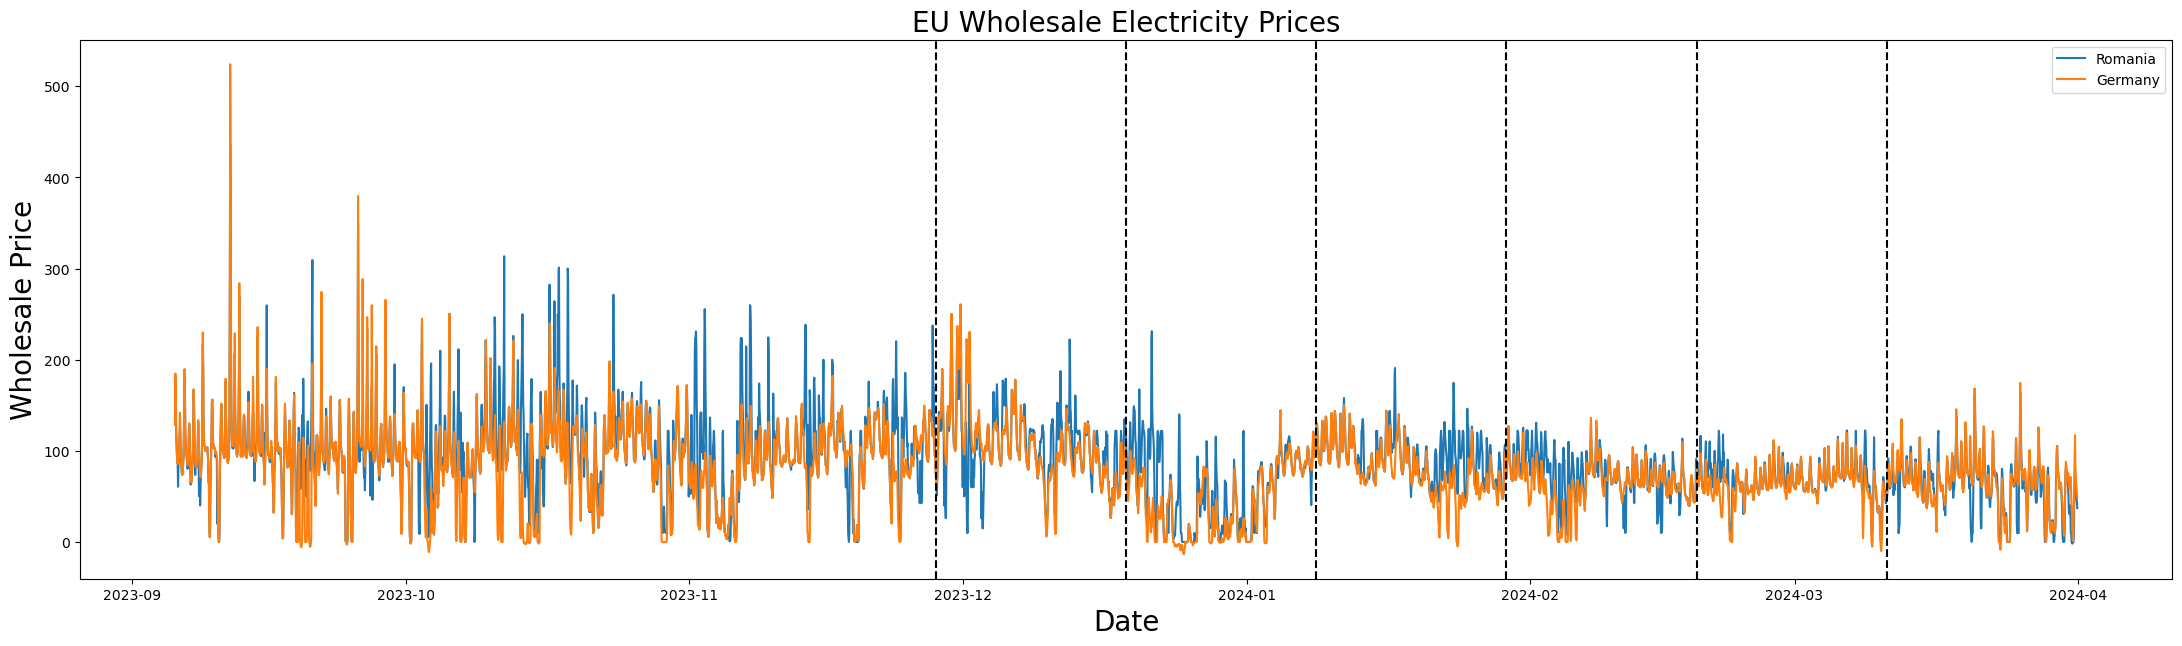

In [ ]:
#Import the data:
with open('data/data_import/EU_Electricity_TimeSeries.pkl','rb') as f:
    eu_df=pickle.load(f)

subsets=list(eu_df['Subset'])

#Visualize the dataset:
plt.figure(figsize=(27,7))
plt.plot(eu_df['Romania (EUR/MWhe)'])
plt.plot(eu_df['Germany (EUR/MWhe)'])

plt.axvline(x = eu_df.index[2000-1], linestyle='dashed',color = 'black')
plt.axvline(x = eu_df.index[2500-1], linestyle='dashed',color = 'black')
plt.axvline(x = eu_df.index[3000-1], linestyle='dashed',color = 'black')
plt.axvline(x = eu_df.index[3500-1], linestyle='dashed',color = 'black')
plt.axvline(x = eu_df.index[4000-1], linestyle='dashed',color = 'black')
plt.axvline(x = eu_df.index[4500-1], linestyle='dashed',color = 'black')

plt.title('EU Wholesale Electricity Prices',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Wholesale Price',fontsize=20)
plt.legend(['Romania','Germany'])
plt.show()
#plt.show()
plt.close()


The dashed lines in the above time series plot highlight the 6 test subsets of 500 time steps used in the walk-forward validation technique. The corresponding train subsets are always selected to be the 2000 time steps preceeding each test subset.

In [ ]:
eu_df.head()

,Austria (EUR/MWhe),Belgium (EUR/MWhe),Bulgaria (EUR/MWhe),Croatia (EUR/MWhe),Czechia (EUR/MWhe),Denmark (EUR/MWhe),Estonia (EUR/MWhe),Finland (EUR/MWhe),France (EUR/MWhe),Germany (EUR/MWhe),...,Portugal (EUR/MWhe),Romania (EUR/MWhe),Serbia (EUR/MWhe),Slovakia (EUR/MWhe),Slovenia (EUR/MWhe),Spain (EUR/MWhe),Sweden (EUR/MWhe),Switzerland (EUR/MWhe),date,Subset
2023-09-05 16:00:00,129.10,129.10,129.10,129.10,129.10,129.10,129.10,18.93,129.10,129.10,...,116.94,129.10,110.26,129.10,129.10,116.94,34.61,120.43,2023-09-05 16:00:00,Train_Set
2023-09-05 17:00:00,181.49,177.73,180.58,178.28,183.18,184.87,183.40,6.33,151.13,184.87,...,139.01,180.58,128.86,182.13,176.98,139.01,35.04,153.87,2023-09-05 17:00:00,Train_Set
2023-09-05 18:00:00,153.70,153.13,152.98,153.53,154.16,154.53,155.28,3.58,149.23,154.53,...,149.23,152.98,131.05,154.16,153.53,149.23,27.79,153.02,2023-09-05 18:00:00,Train_Set
2023-09-05 19:00:00,121.95,121.95,121.95,121.95,121.95,121.95,121.95,1.75,121.95,121.95,...,141.18,121.95,113.30,121.95,121.95,141.18,20.82,124.78,2023-09-05 19:00:00,Train_Set
2023-09-05 20:00:00,107.61,107.61,107.61,107.61,107.61,107.61,107.61,0.05,107.61,107.61,...,137.76,107.61,111.32,107.61,107.61,137.76,0.67,108.98,2023-09-05 20:00:00,Train_Set


### **2. Data Preprocessing**

In this section the data is preprocessed, i.e., split into different train and test subsets based on the requirements of each of the models included in the study, using the class **Multivaraite_TimeSeries_Preprocesser**. As different models require slightly different data prerocessing, e.g., some models make use of time covariates (transformers), while other models do not require timestamp data, the function preprocess_data takes as an input a list containing the names of the time series models. For this reason, in a loop, the dataloaders are saved for the different models in a dictionary, which will be used in the third section during the model training and testing.

In [ ]:
current_multivariate_models=['Basisformer','Autoformer','Informer','PatchTST','Quatformer','DLinear','NLinear','TSMixer']
timeseries_preprocessor=Multivaraite_TimeSeries_Preprocesser(df=eu_df,
                                                             train_size=2000,test_size=500,
                                                             seq_len=96,pred_len=96,batch_size=32)

models_dataloaders_dict=timeseries_preprocessor.preprocess_data(current_multivariate_forecasters=current_multivariate_models)

### **3. Model Training**

a) Multivariate Time Series Models:

In this section, the models are trained and tested with walk-forward validation using the class **Multivariate_Forecasting**. The dictionary models_dataloaders_dict is used to retrieve the datasets, preprocessed for the technical requirements of each supported model.

In [ ]:
multivariate_forecasting=Multivariate_Forecasting(df=eu_df,
                                                models_dataloaders_dict=models_dataloaders_dict,
                                                time_series_models_dict=time_series_models_dict,
                                                reverse_rescale=True)
all_models_results=multivariate_forecasting.perform_walk_forward_validation()

#Save the results from each model in a separate pickle file:
for current_model in all_models_results.keys():
    with open('evaluation/Results/'+current_model+'_Results_per_Subset.pkl','wb') as f:
            pickle.dump(all_models_results[current_model],f)

b) Univariate Time Series Forecasting: ARIMA, Chronos, TimesFM

In this section the univariate forecasting techniques are applied to the electricity price dataset using the class **Univariate_Forecasting**. While ARIMA requires training, TimesFM and Chronos represent zero-shot forecasting techniques. Each of the 3 models supports an iterative predictive approach, which requires looping through each country to forecast the next 96 time steps in a sequential manner.

In [ ]:
univariate_forecasting=Univariate_Forecasting(df=eu_df,train_size=2000,
                                              test_size=500,seq_len=96,
                                              pred_len=96,n_splits=6,
                                              univariate_forecasters=['ARIMA','Chronos','TimesFM'])
all_univariate_forecasting_results=univariate_forecasting.compute_predictions()

for univariate_forecaster in all_univariate_forecasting_results.keys():
    with open('evaluation/Results/'+univariate_forecaster+'_Results_per_Subset.pkl','wb') as f:
        pickle.dump(all_univariate_forecasting_results[univariate_forecaster],f)